Copyright 2020 DeepMind Technologies Limited. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Full license text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LSTMs in Haiku

**[Haiku](https://github.com/deepmind/dm-haiku) is a simple neural network library for [JAX](https://github.com/google/jax).**

This notebook walks through a simple LSTM in JAX with Haiku.

For first-time Haiku users, we recommend that you first check out out our [Quickstart](https://github.com/deepmind/dm-haiku#quickstart) and [MNIST example](https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py) first.

## Setup

In [1]:
!pip install dm-haiku optax

In [2]:
import math
from typing import Tuple, TypeVar
import warnings

import haiku as hk
import jax
import jax.numpy as jnp
import optax
import numpy as np
import pandas as pd
import plotnine as gg

T = TypeVar('T')
Pair = Tuple[T, T]

gg.theme_set(gg.theme_bw())
warnings.filterwarnings('ignore')

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/home/don/mltests-venv/lib/python3.8/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


## Generating Data

In this notebook, we generate many sine waves (of the same period), and try to predict the next value in the wave based on its previous values.

For simplicity, we generate static-sized datasets and wrap them with an iterator-based API.

In [3]:
def sine_seq(
    phase: float,
    seq_len: int,
    samples_per_cycle: int,
) -> Pair[np.ndarray]:
  """Returns x, y in [T, B] tensor."""
  t = np.arange(seq_len + 1) * (2 * math.pi / samples_per_cycle)
  t = t.reshape([-1, 1]) + phase
  sine_t = np.sin(t)
  return sine_t[:-1, :], sine_t[1:, :]


def generate_data(
    seq_len: int,
    train_size: int,
    valid_size: int,
) -> Pair[Pair[np.ndarray]]:
  phases = np.random.uniform(0., 2 * math.pi, [train_size + valid_size])
  all_x, all_y = sine_seq(phases, seq_len, 3 * seq_len / 4)

  all_x = np.expand_dims(all_x, -1)
  all_y = np.expand_dims(all_y, -1)
  train_x = all_x[:, :train_size]
  train_y = all_y[:, :train_size]

  valid_x = all_x[:, train_size:]
  valid_y = all_y[:, train_size:]

  return (train_x, train_y), (valid_x, valid_y)


class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""

  def __init__(self, xy: Pair[np.ndarray], batch_size: int):
    self._x, self._y = xy
    self._batch_size = batch_size
    self._length = self._x.shape[1]
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  def __next__(self) -> Pair[np.ndarray]:
    start = self._idx
    end = start + self._batch_size
    x, y = self._x[:, start:end], self._y[:, start:end]
    if end >= self._length:
      end = end % self._length
      assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x, y

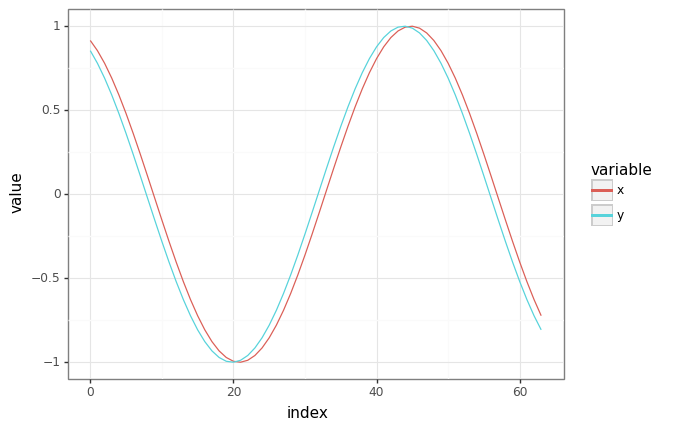

In [4]:
TRAIN_SIZE = 2 ** 14
VALID_SIZE = 128
BATCH_SIZE = 8
SEQ_LEN = 64

train, valid = generate_data(SEQ_LEN, TRAIN_SIZE, VALID_SIZE)

# Plot an observation/target pair.
df = pd.DataFrame({'x': train[0][:, 0, 0], 'y': train[1][:, 0, 0]}).reset_index()
df = pd.melt(df, id_vars=['index'], value_vars=['x', 'y'])
plot = gg.ggplot(df) + gg.aes(x='index', y='value', color='variable') + gg.geom_line()
plot.draw()

train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)
del train, valid  # Don't leak temporaries.

In [8]:
next(train_ds)[0].shape

(64, 8, 1)

## Training an LSTM

To train the LSTM, we define a Haiku function which unrolls the LSTM over the input sequence, generating predictions for all output values. The LSTM always starts with its initial state at the start of the sequence.

The Haiku function is then transformed into a pure function through `hk.transform`, and is trained with Adam on an L2 prediction loss.

In [9]:
def unroll_net(seqs: jnp.ndarray):
  """Unrolls an LSTM over seqs, mapping each output to a scalar."""
  # seqs is [T, B, F].
  core = hk.LSTM(32)
  batch_size = seqs.shape[1]
  outs, state = hk.dynamic_unroll(core, seqs, core.initial_state(batch_size))
  # We could include this Linear as part of the recurrent core!
  # However, it's more efficient on modern accelerators to run the linear once
  # over the entire sequence than once per sequence element.
  return hk.BatchApply(hk.Linear(1))(outs), state


model = hk.transform(unroll_net)


def train_model(train_ds: Dataset, valid_ds: Dataset) -> hk.Params:
  """Initializes and trains a model on train_ds, returning the final params."""
  rng = jax.random.PRNGKey(428)
  opt = optax.adam(1e-3)

  @jax.jit
  def loss(params, x, y):
    pred, _ = model.apply(params, None, x)
    return jnp.mean(jnp.square(pred - y))

  @jax.jit
  def update(step, params, opt_state, x, y):
    l, grads = jax.value_and_grad(loss)(params, x, y)
    grads, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, grads)
    return l, params, opt_state

  # Initialize state.
  sample_x, _ = next(train_ds)
  params = model.init(rng, sample_x)
  opt_state = opt.init(params)

  for step in range(2001):
    if step % 100 == 0:
      x, y = next(valid_ds)
      print("Step {}: valid loss {}".format(step, loss(params, x, y)))

    x, y = next(train_ds)
    train_loss, params, opt_state = update(step, params, opt_state, x, y)
    if step % 100 == 0:
      print("Step {}: train loss {}".format(step, train_loss))

  return params

In [10]:
trained_params = train_model(train_ds, valid_ds)

Step 0: valid loss 0.4450095295906067
Step 0: train loss 0.43516790866851807
Step 100: valid loss 0.034317828714847565
Step 100: train loss 0.033796004951000214
Step 200: valid loss 0.021666496992111206
Step 200: train loss 0.02299770712852478
Step 300: valid loss 0.0158965103328228
Step 300: train loss 0.017148301005363464
Step 400: valid loss 0.010721780359745026
Step 400: train loss 0.013273733668029308
Step 500: valid loss 0.009210474789142609
Step 500: train loss 0.009408616460859776
Step 600: valid loss 0.006826357915997505
Step 600: train loss 0.005771923810243607
Step 700: valid loss 0.005738710984587669
Step 700: train loss 0.005494994111359119
Step 800: valid loss 0.00457376753911376
Step 800: train loss 0.004642548970878124
Step 900: valid loss 0.00411306181922555
Step 900: train loss 0.004229109734296799
Step 1000: valid loss 0.0027125878259539604
Step 1000: train loss 0.0033433600328862667
Step 1100: valid loss 0.0022937324829399586
Step 1100: train loss 0.0029248828068375

## Sampling

The point of training models is so that they can make predictions! How can we generate predictions with the trained model?

If we're allowed to feed in the ground truth, we can just run the original model's `apply` function.

In [11]:
def plot_samples(truth: np.ndarray, prediction: np.ndarray) -> gg.ggplot:
  assert truth.shape == prediction.shape
  df = pd.DataFrame({'truth': truth.squeeze(), 'predicted': prediction.squeeze()}).reset_index()
  df = pd.melt(df, id_vars=['index'], value_vars=['truth', 'predicted'])
  plot = (
      gg.ggplot(df)
      + gg.aes(x='index', y='value', color='variable')
      + gg.geom_line()
  )
  return plot

In [13]:
# Grab a sample from the validation set.
sample_x, _ = next(valid_ds)
sample_x = sample_x[:, :1]  # Shrink to batch-size 1.

# Generate a prediction, feeding in ground truth at each point as input.
predicted, _ = model.apply(trained_params, None, sample_x)

plot = plot_samples(sample_x[1:], predicted[:-1])
plot.draw()
del sample_x, predicted

# Typically: the beginning of the predictions are a bit wonky, but the curve
# quickly smoothes out.

If we can't feed in the ground truth (because we don't have it), we can also run the model autoregressively.

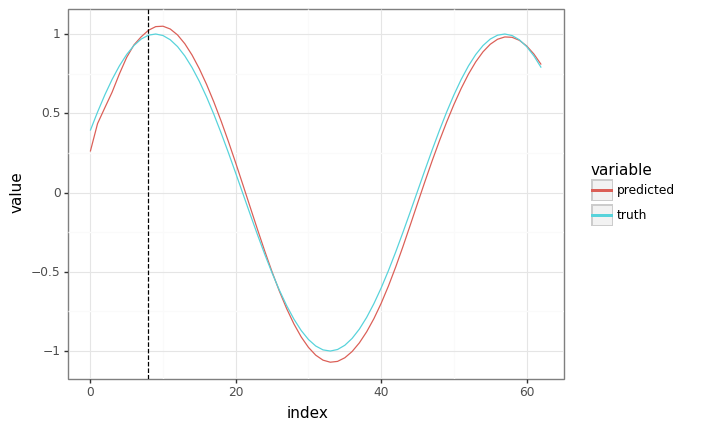

In [17]:
def autoregressive_predict(
    trained_params: hk.Params,
    context: jnp.ndarray,
    seq_len: int,
):
  """Given a context, autoregressively generate the rest of a sine wave."""
  ar_outs = []
  context = jax.device_put(context)
  for _ in range(seq_len - context.shape[0]):
    full_context = jnp.concatenate([context] + ar_outs)
    outs, _ = jax.jit(model.apply)(trained_params, None, full_context)
    # Append the newest prediction to ar_outs.
    ar_outs.append(outs[-1:])
  # Return the final full prediction.
  return outs


sample_x, _ = next(valid_ds)
context_length = SEQ_LEN // 8
# Cut the batch-size 1 context from the start of the sequence.
context = sample_x[:context_length, :1]

# We can reuse params we got from training for inference - as long as the
# declaration order is the same.
predicted = autoregressive_predict(trained_params, context, SEQ_LEN)

plot = plot_samples(sample_x[1:, :1], predicted)
plot += gg.geom_vline(xintercept=len(context), linetype='dashed')
plot.draw()
#del predicted

In [29]:
type(sample_x)

numpy.ndarray

### Sharing parameters with a different function.

Unfortunately, this is a bit slow - we're doing O(N^2) computation for a sequence of length N.

It'd be better if we could do the autoregressive sampling all at once - but we need to write a new Haiku function for that.

We're in luck - if the Haiku module names match, the same parameters can be used for multiple Haiku functions.

This can be achieved through a combination of two techniques:

1. If we manually give a unique name to a module, we can ensure that the parameters are directed to the right places.
2. If modules are instantiated in the same order, they'll have the same names in different functions.

Here, we rely on method #2 to create a fast autoregressive prediction.

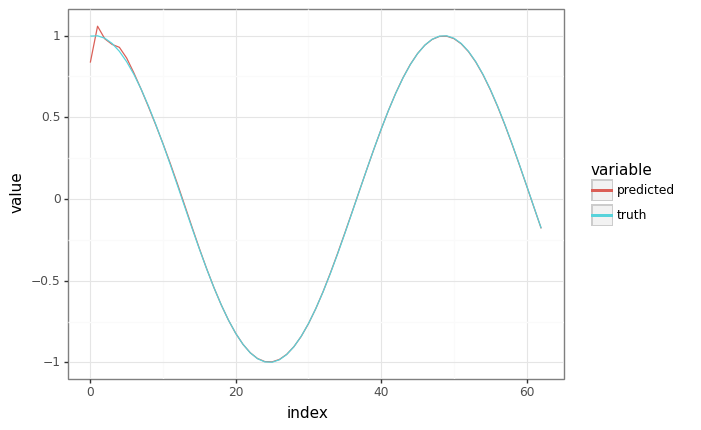

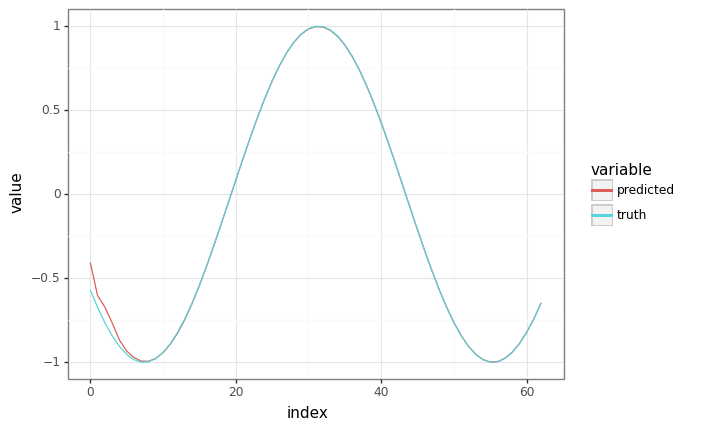

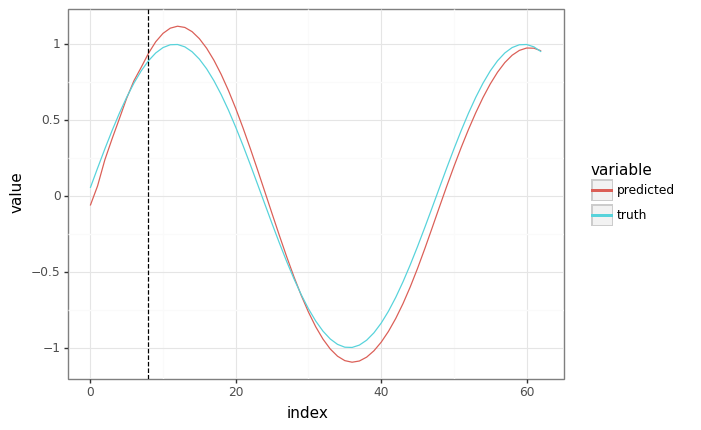

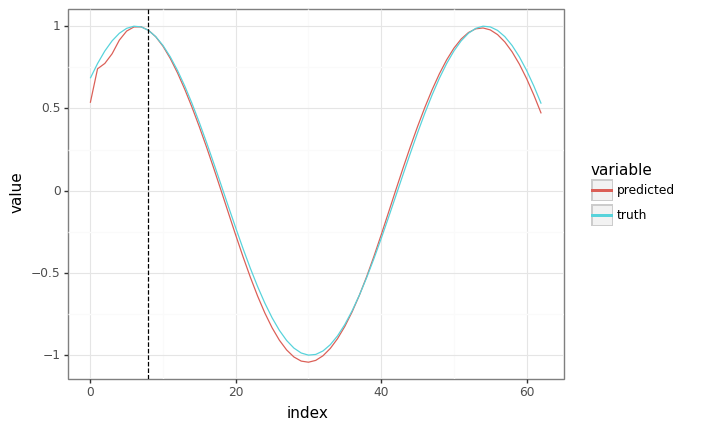

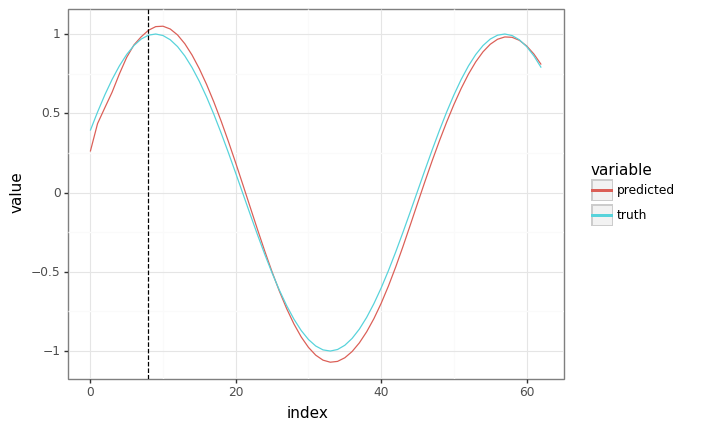

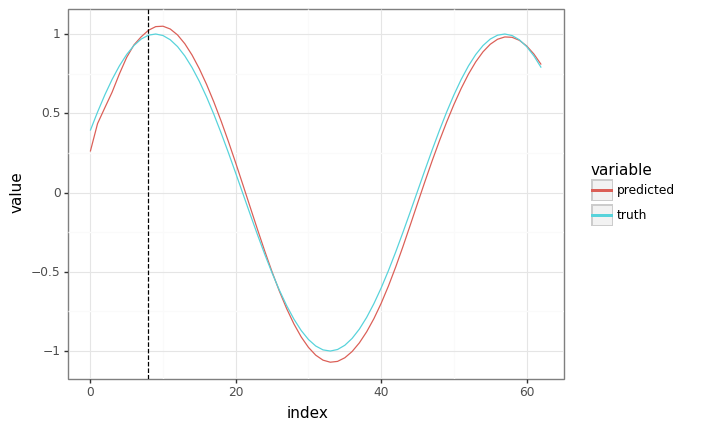

<ggplot: (8788245577186)>

In [30]:
def fast_autoregressive_predict_fn(context, seq_len):
  """Given a context, autoregressively generate the rest of a sine wave."""
  core = hk.LSTM(32)
  dense = hk.Linear(1)
  state = core.initial_state(context.shape[1])
  # Unroll over the context using `hk.dynamic_unroll`.
  # As before, we `hk.BatchApply` the Linear for efficiency.
  context_outs, state = hk.dynamic_unroll(core, context, state)
  context_outs = hk.BatchApply(dense)(context_outs)

  # Now, unroll one step at a time using the running recurrent state.
  ar_outs = []
  x = context_outs[-1]
  for _ in range(seq_len - context.shape[0]):
    x, state = core(x, state)
    x = dense(x)
    ar_outs.append(x)
  return jnp.concatenate([context_outs, jnp.stack(ar_outs)])


fast_ar_predict = hk.transform(fast_autoregressive_predict_fn)
fast_ar_predict = jax.jit(fast_ar_predict.apply, static_argnums=3)
# Reuse the same context from the previous cell.
predicted = fast_ar_predict(trained_params, None, context, SEQ_LEN)
# The plots should be equivalent!
plot = plot_samples(sample_x[1:, :1], predicted[:-1])
plot += gg.geom_vline(xintercept=len(context), linetype='dashed')
plot

In [31]:
%timeit autoregressive_predict(trained_params, context, SEQ_LEN)
%timeit fast_ar_predict(trained_params, None, context, SEQ_LEN)

977 ms ± 70.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.6 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
